In [63]:
%matplotlib inline

import sys
import os
import numpy as np
import xarray as xr
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt, animation, rc
from datetime import datetime, timedelta
from dateutil.parser import parse
from cartopy import crs, feature
import cmocean

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from OP_functions_uniform import *

In [64]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)

In [65]:
batt=xr.open_dataset(paths['mask'],decode_times=False)
coord=xr.open_dataset(paths['coords'],decode_times=False)
#clat,clon = p_unidist(coord.gphif[0,:,:],coord.glamf[0,:,:],batt.mbathy[0,:,:],10,10)
with open('clat.txt') as f:
    clat = f.read()
    clat= clat[1:-1]
    clat0 = clat.split(",")
    f.close()
with open('clon.txt') as f:
    clon = f.read()
    clon=clon[1:-1]
    clon0 = clon.split(",")
    f.close()

clat,clon=[],[]
for i in range(len(clat0)):
    clat.append(float(clat0[i]))
    clon.append(float(clon0[i]))


## THIS MUST BE THE SAME USED WHEN RUNNING PARCELS

In [66]:
start = datetime(2018, 10, 1) #Start date
# Set Time length [days] and timestep [seconds]
length = 35
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards
N = len(clat) # number of deploying locations
n = 1 # 1000   # number of particles per location
dmin = list(np.zeros(len(clat)))
#dmin = [0,0,0,0,0,70] #minimum depth
dd = 5 #max depth difference from dmin
x_offset, y_offset, zvals = p_deploy(N,n,dmin,dd)

In [67]:
# Set output file name.  Maybe change for each run
fn = 'uniformT' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [68]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]

In [69]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
#clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,float(outf_lon)], [49.186308,49.975326,49.305448,47.622403,48.399420,float(outf_lat)]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [70]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

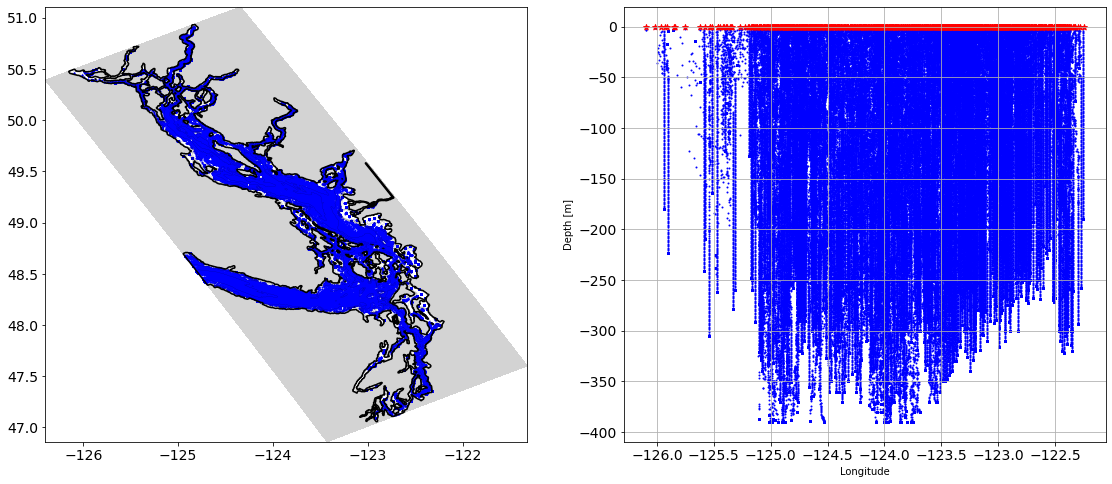

In [71]:
visual(outfile,N,n,clon,clat,dmin,dd,0,-1,local)

### Calculate displacement

In [72]:
d=[]
for i in range(len(clon)):
    d.append(dist_coord(ds.lat[i,:],ds.lon[i,:]))

In [73]:
dt=[]
for i in range(len(clat)):
    sedi = np.where(ds.sediment[i,:]==1)
    if len(sedi[0])>1:
        dt.append((sedi[0][0])/24)

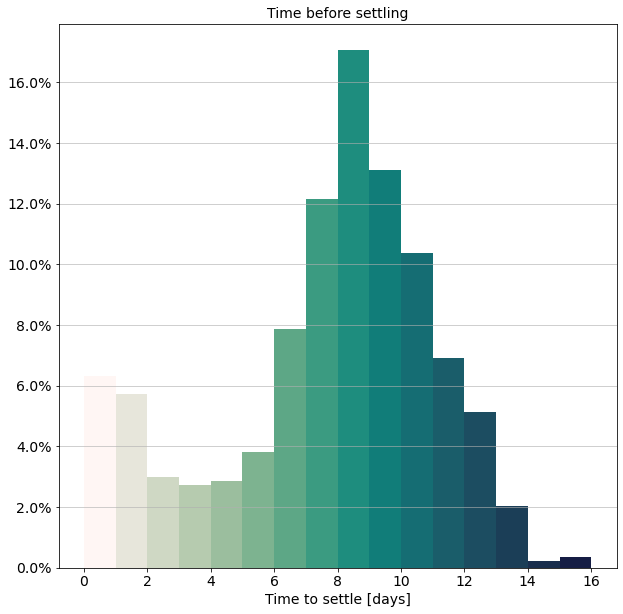

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
fs=14
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs 
from matplotlib.ticker import PercentFormatter
dist=np.arange(0,np.max(dt),1)
n, bins, patches=plt.hist(dt,dist,weights=np.ones(len(dt)) / len(dt))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Time to settle [days]',fontsize=fs)
plt.title('Time before settling',fontsize=fs)


cm = cmocean.cm.tempo
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

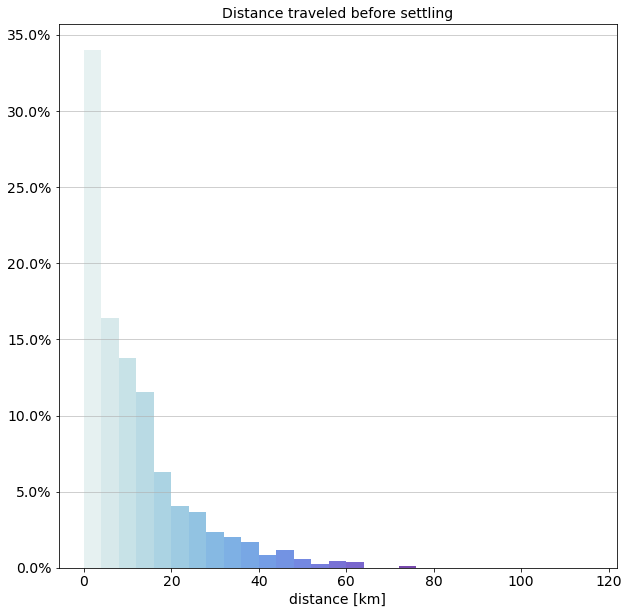

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
fs=14
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs 
from matplotlib.ticker import PercentFormatter
dist=np.arange(0,120,4)
n, bins, patches=plt.hist(d,dist,weights=np.ones(len(d)) / len(d))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('distance [km]',fontsize=fs)
plt.title('Distance traveled before settling',fontsize=fs)


cm = cmocean.cm.dense
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

/tmp/ipykernel_24795/1115348410.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  cb.set_label('[km]', rotation=270,Fontsize=14)


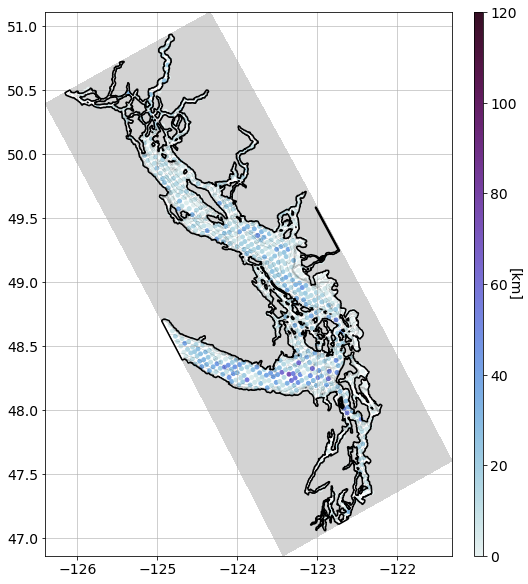

In [80]:
nmin=0
nmax=1
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 
fig, ax = plt.subplots(figsize=(40, 10))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
dd=ax.scatter(ds.lon[:, nmin:nmax], ds.lat[:, nmin:nmax],s=15, c=d, cmap=cmocean.cm.dense)
dd.set_clim(0,120)
cb=plt.colorbar(dd,aspect=60,pad=0.01)
cb.set_label('[km]', rotation=270,Fontsize=14)
plt.grid(alpha=0.75)
ax.set_aspect(1.6)

In [77]:
# fps=3
# anim = mapanimation(outfile,N,n,clon,clat,fps,local)
# f = r"/home/jvalenti/MOAD/animations/fibres2.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)


In [78]:
# with open(f,'rb') as anim:
#     display(Image(anim.read()))